# Introduction

This a study on time series using statsmodels and prophet.

Guided through a series of videos you can find on [Téo Calvo YouTube Channel](https://www.youtube.com/@teomewhy)

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

matplotlib.rcParams['figure.figsize'] = [16,4]
pd.set_option('display.max_columns', 100)

In [3]:
df = pd.read_csv('../data/dfTimeSeries_Example1.csv')

In [4]:
df.head()

,dept_id,state_id,cat_id,d,date,event_name_1,event_type_1,value_sales,sell_price
0,FOODS_1,CA,FOODS,d_1,2011-01-29,NaN,NaN,297,2.989109
1,FOODS_1,CA,FOODS,d_10,2011-02-07,NaN,NaN,176,3.016636
2,FOODS_1,CA,FOODS,d_100,2011-05-08,Mother's day,Cultural,211,2.987851
3,FOODS_1,CA,FOODS,d_1000,2013-10-24,NaN,NaN,243,3.237990
4,FOODS_1,CA,FOODS,d_1001,2013-10-25,NaN,NaN,331,3.237990


In [7]:
df.info()

<class 'pandas.DataFrame'>
Index: 5915 entries, 78 to 12494
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dept_id       5915 non-null   str           
 1   state_id      5915 non-null   str           
 2   cat_id        5915 non-null   str           
 3   d             5915 non-null   str           
 4   date          5915 non-null   datetime64[us]
 5   event_name_1  483 non-null    str           
 6   event_type_1  483 non-null    str           
 7   value_sales   5915 non-null   int64         
 8   sell_price    5915 non-null   float64       
dtypes: datetime64[us](1), float64(1), int64(1), str(6)
memory usage: 462.1 KB


Just skipping a few steps ahead, theres a few missing before 2014 on this database, so thats why we are taking the dates after that.

In [6]:
df['date'] = pd.to_datetime(df.date)
df = df[df['date'] >= '2014-01-01']

Let's filter some of the departments so we can forecast of them separately

In [8]:
df.dept_id.unique()

<StringArray>
[    'FOODS_1',     'FOODS_2',     'FOODS_3',   'HOBBIES_1',   'HOBBIES_2',
 'HOUSEHOLD_1', 'HOUSEHOLD_2']
Length: 7, dtype: str

In [9]:
df_hobbies1 = df.loc[df['dept_id'] == 'HOBBIES_1', : ]
df_hobbies1.index = df_hobbies1.date

In [10]:
df_hh1 = df.loc[df['dept_id'] == 'HOUSEHOLD_1', : ]
df_hh1.index = df_hh1.date

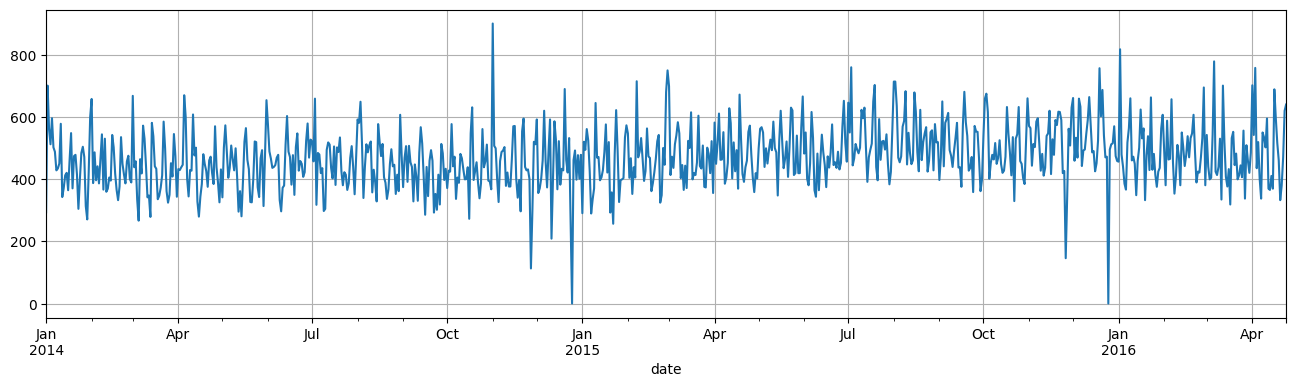

In [12]:
df_hobbies1['value_sales'].plot(grid = True);

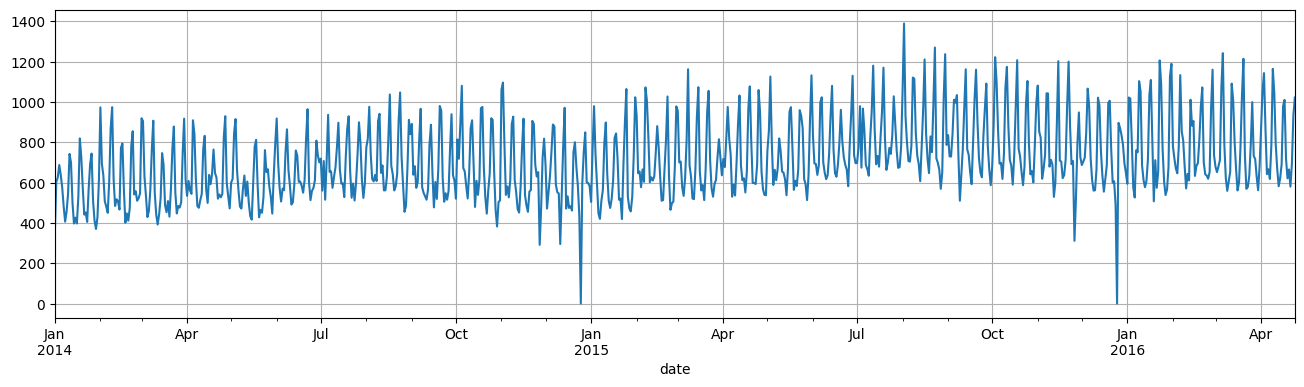

In [13]:
df_hh1['value_sales'].plot(grid = True);

in this example `value_sales` stands for quantity of sales.

# 1st Concept - Correlation between series

Sometimes is common for two series to fluctuate together.

Correlation between series: 66.56%


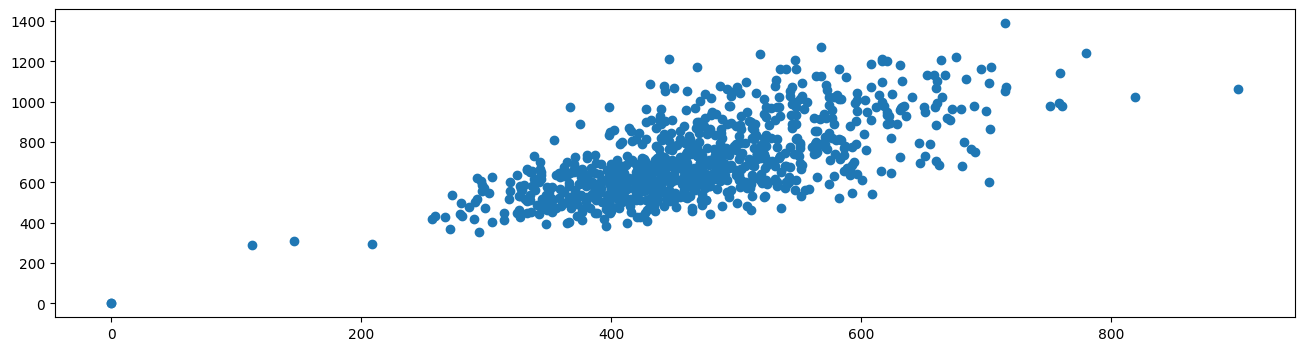

In [33]:
corr = df_hobbies1['value_sales'].corr(df_hh1['value_sales'])
print(f"Correlation between series: {corr:.2%}")

plt.scatter(df_hobbies1['value_sales'], df_hh1['value_sales'])
plt.show()

$
\rho = 1 \text{ Positive correlation} \\\\
\rho = -1 \text{ Negative correlation} \\\\
\rho = 0 \text{ No correlation} \\\\
$

In [35]:
diffs_hobbies1 = df_hobbies1.loc[:,['value_sales']].diff().dropna()
diffs_hobbies1 = diffs_hobbies1[diffs_hobbies1['value_sales'] < float('inf')]

diffs_hh1 = df_hh1.loc[:,['value_sales']].diff().dropna()
diffs_hh1 = diffs_hh1[diffs_hh1['value_sales'] < float('inf')]

We make this to take off the tendency of the series. -- REVIEW THIS LATER

In [36]:
corr = diffs_hobbies1['value_sales'].corr(diffs_hh1['value_sales'])
print(f"Correlation between the diferences of the two series: {corr:.2%}")

Correlation between the diferences of the two series: 53.21%


# 2nd Concept - Autocorrelation and partial autocorrelation

The autocorrelation of a series is the correlation of the series with a lagged version of itself.

In [37]:
df_hobbies1.loc[:,'lag1_sales'] = df_hobbies1.value_sales.shift(1)
df_hobbies1.loc[:,['dept_id', 'value_sales', 'lag1_sales']].head()

,dept_id,value_sales,lag1_sales
date,,,
2014-01-01,HOBBIES_1,294,NaN
2014-01-02,HOBBIES_1,702,294.0
2014-01-03,HOBBIES_1,565,702.0
2014-01-04,HOBBIES_1,513,565.0
2014-01-05,HOBBIES_1,597,513.0


In [41]:
autocorr_hobbies1 = df_hobbies1['value_sales'].autocorr()
print(f"The autocorrelation of the diary sales with lag 1 is: {autocorr_hobbies1:.2%}")

The autocorrelation of the diary sales with lag 1 is: 26.42%


In [42]:
autocorr_hh1 = df_hh1['value_sales'].autocorr()
print(f"The autocorrelation of the diary sales with lag 1 is: {autocorr_hh1:.2%}")

The autocorrelation of the diary sales with lag 1 is: 53.89%


For stocks, a lot of multimarket funds strategies are bases on autocorrelation of the returns.

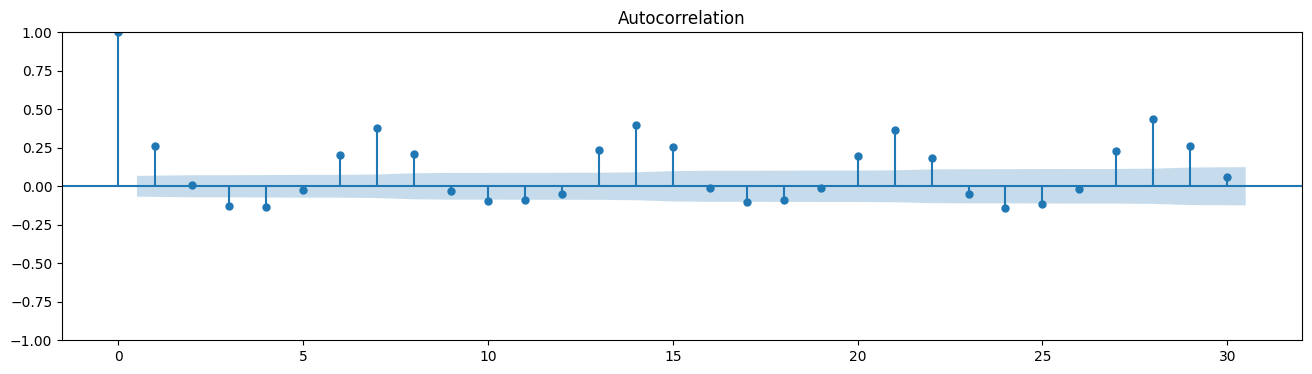

In [47]:
plot_acf(df_hobbies1['value_sales'], alpha = 0.05);

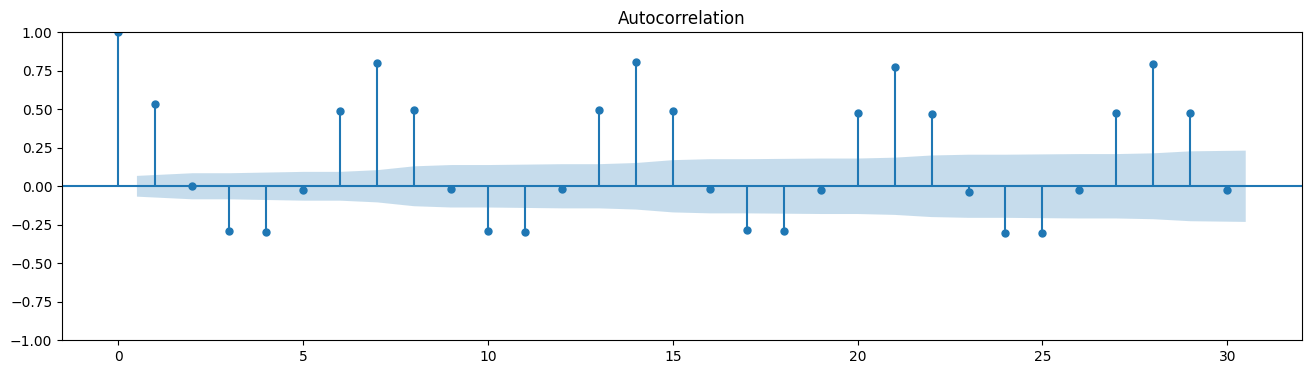

In [48]:
plot_acf(df_hh1['value_sales'], alpha = 0.05);

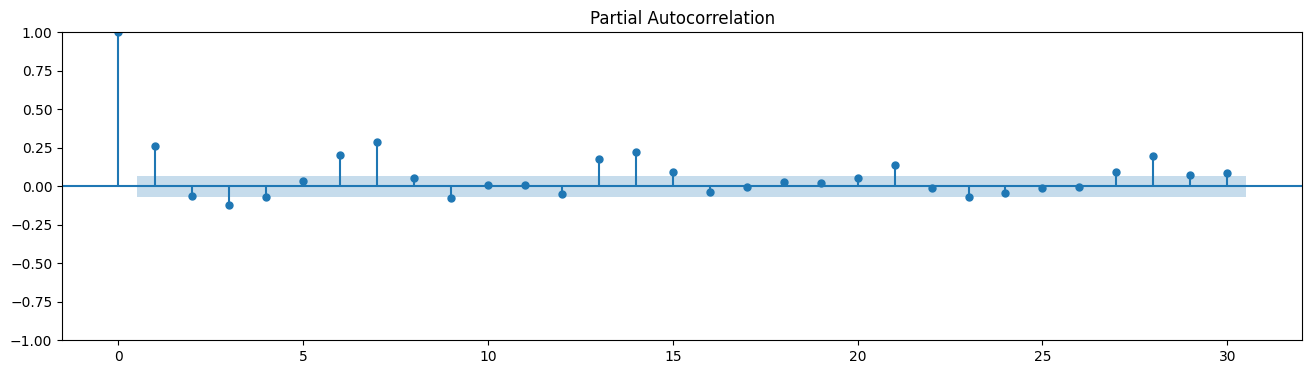

In [49]:
plot_pacf(df_hobbies1['value_sales'], alpha = 0.05);

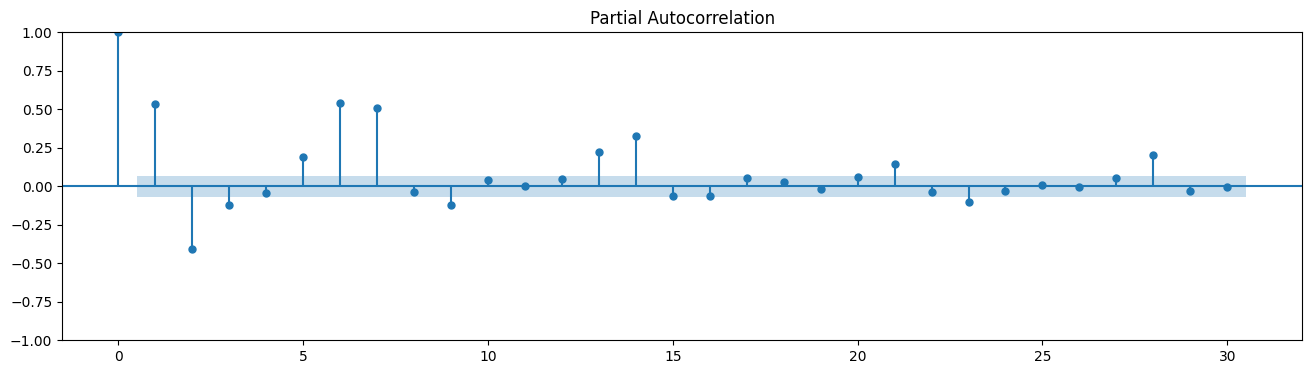

In [51]:
plot_pacf(df_hh1['value_sales'], alpha = 0.05);

partial autocorrelation answers what a period of it explains of the last iteration if the iterations in between were already accountable

In [ ]:
# df.resample(rule = 'w').last()
# just for annotation, this code would remake the database with the period per week 

# 3rd Concept - Random time series (white noise and random walk)

The definition of white noise is:
- Constant average through time
- Constant deviation through time
- 0 autocorrelation

**Remember: no autocorrelation doesn't mean its not predictable, the 3 concepts must be true for it to be.**

<Figure size 1600x400 with 0 Axes>

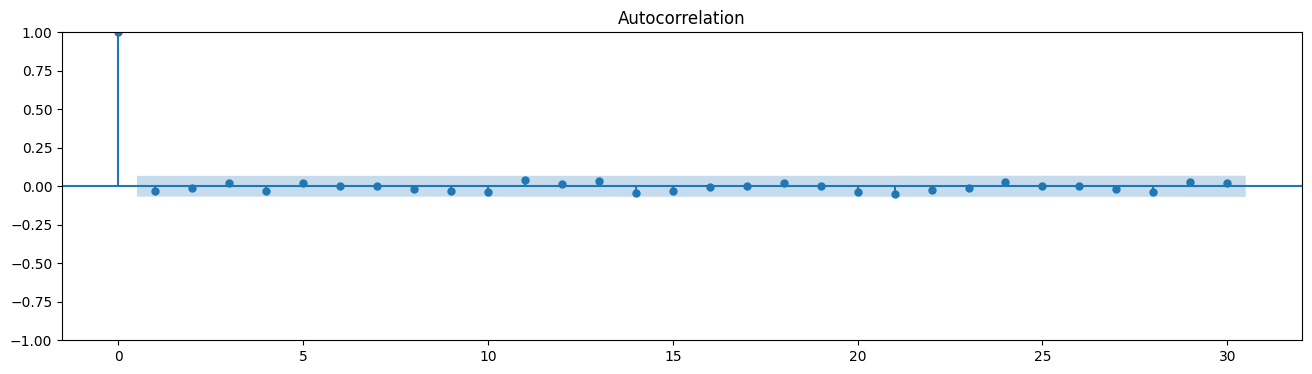

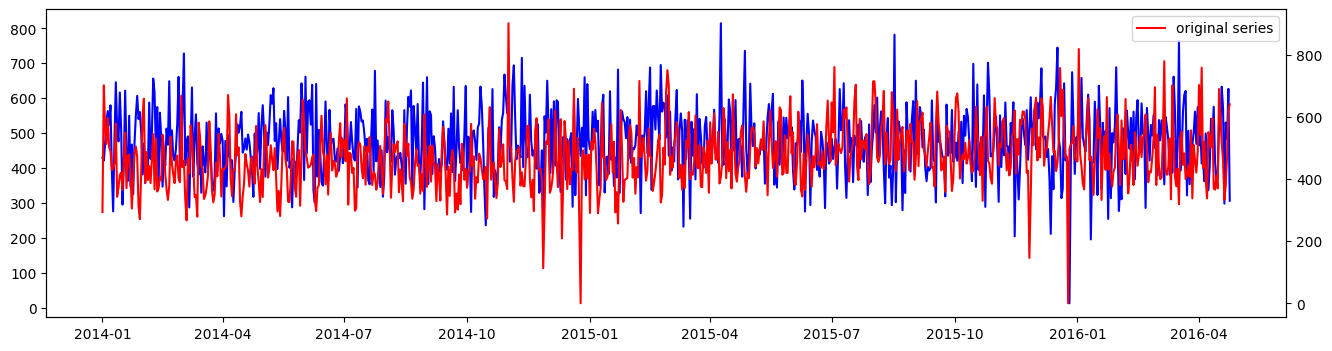

In [58]:
# Average and standard devation of hobbies 1 - to plot a series witht noise
mean_hobbies1 = df_hobbies1['value_sales'].mean()
std_hobbies1 = df_hobbies1['value_sales'].std()
ruido = np.random.normal(mean_hobbies1, std_hobbies1, df_hobbies1.shape[0])
plt.clf()
plot_acf(ruido)


fig, ax = plt.subplots()
ax.plot(df_hobbies1.index, ruido, color='blue')
ax2 = ax.twinx()
ax2.plot(df_hobbies1.index, df_hobbies1["value_sales"], color='red',label='original series')
plt.legend()
plt.show()

the blue on the second chart is the noise series showing no sazonality.

# 4th Concept - Stationarity



cicles and sazonality are different concepts, sazonality is when the cicles repeat between the same period of times. Sometimes a series will have cicles but it will not be on the same period, so it can be stationary.